# Linear Regression

Let's set some setting for this Jupyter Notebook.

In [2]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Now, let's import the `LinearRegression` model from the `pymc-learn` package.

In [3]:
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

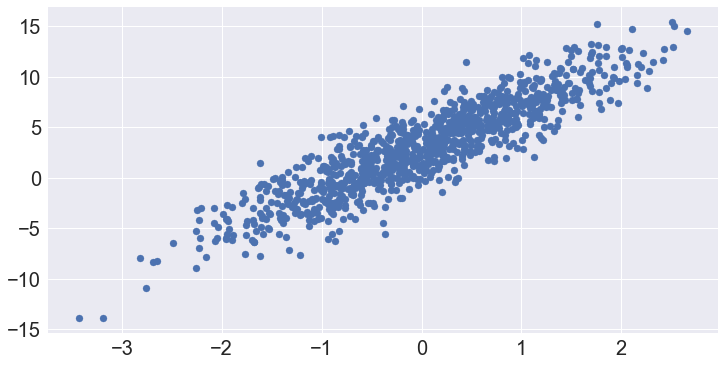

In [5]:
X = np.random.randn(1000, 1)
noise = 2 * np.random.randn(1000, 1)
slope = 4
intercept = 3
y = slope * X + intercept + noise
y = np.squeeze(y)

fig, ax = plt.subplots()
ax.scatter(X, y);

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Step 2: Instantiate a model

In [7]:
model = LinearRegression()

## Step 3: Perform Inference

In [9]:
model.fit(X_train, y_train)

Average Loss = 1,515.2:  14%|█▎        | 27356/200000 [00:12<01:18, 2199.11it/s]
Convergence archived at 27500
Interrupted at 27,499 [13%]: Average Loss = 3,823


LinearRegression()

## Step 4: Diagnose convergence

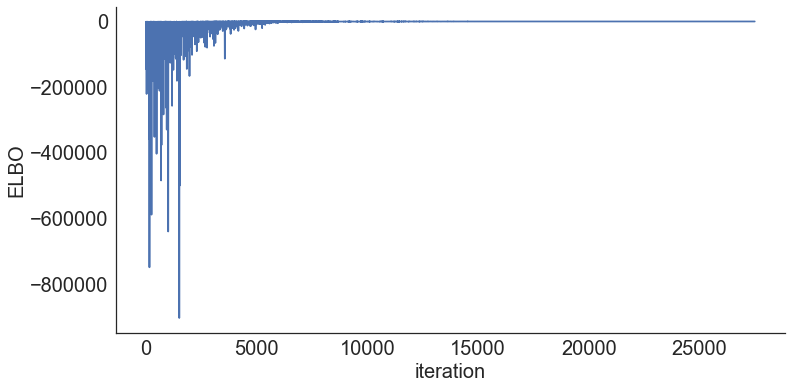

In [10]:
model.plot_elbo()

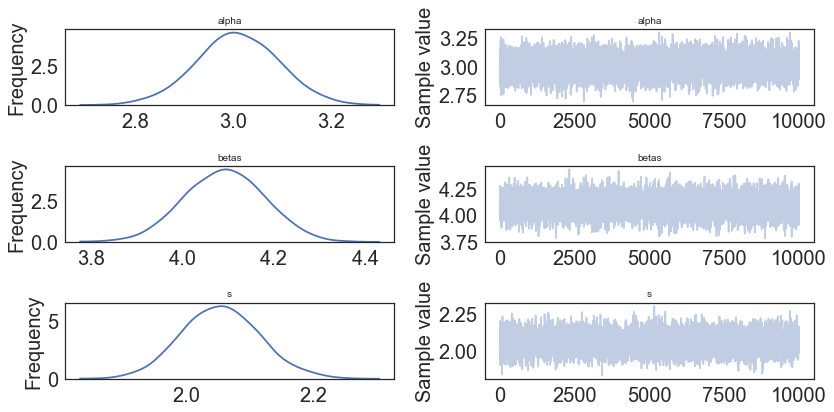

In [11]:
pm.traceplot(model.trace);

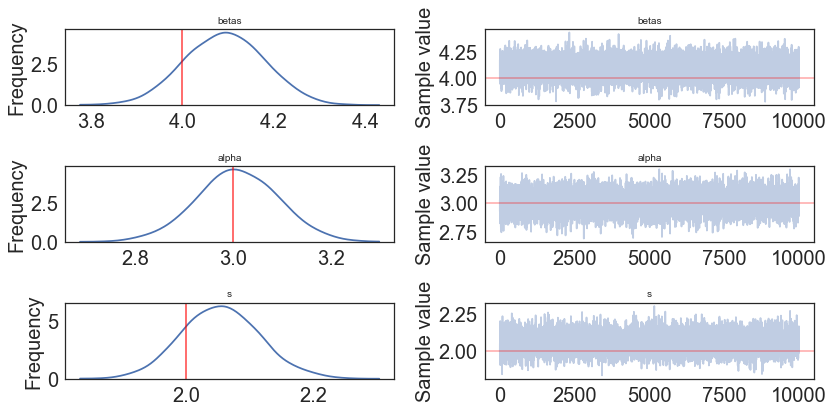

In [16]:
pm.traceplot(model.trace, lines = {"betas": slope, 
                                 "alpha": intercept, 
                                 "s": 2}, 
             varnames=["betas", "alpha", "s"]);

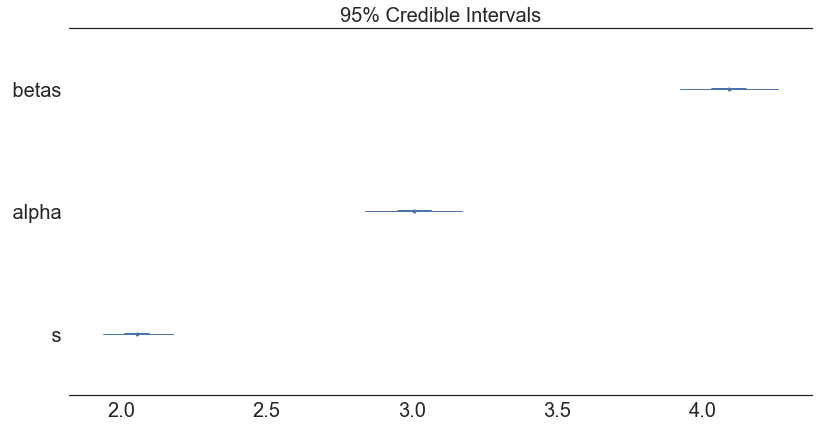

In [17]:
pm.forestplot(model.trace, varnames=["betas", "alpha", "s"]);

## Step 5: Critize the model

In [18]:
pm.summary(model.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
betas__0_0,4.092173,0.087328,0.000778,3.923620,4.261150
alpha__0,3.009011,0.084624,0.000882,2.836815,3.172059
s,2.054613,0.060952,0.000542,1.934845,2.176337


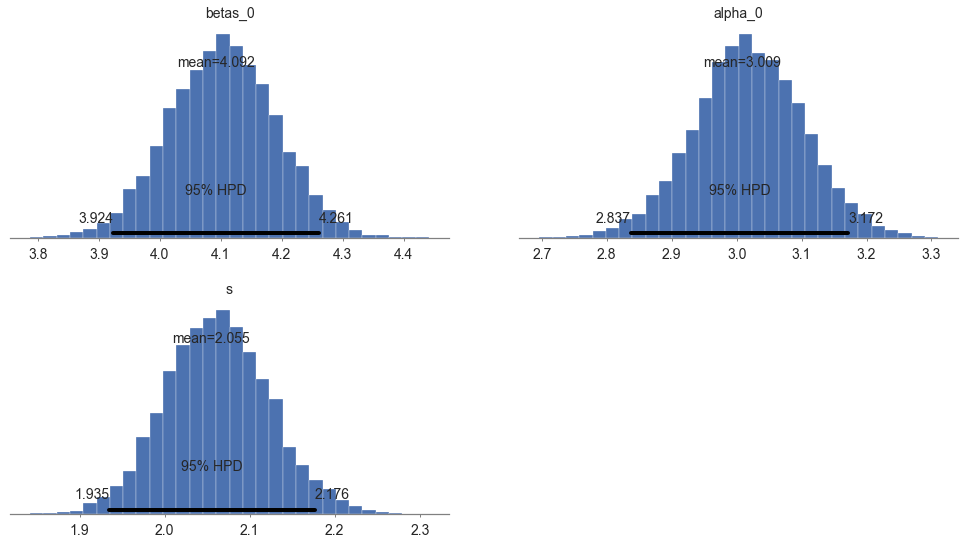

In [19]:
pm.plot_posterior(model.trace, varnames=["betas", "alpha", "s"], 
                 figsize = [14, 8]);

In [26]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["betas", "alpha", "s"],
              "Parameter-Learned (Mean Value)": [float(model.trace["betas"].mean(axis=0)), 
                               float(model.trace["alpha"].mean(axis=0)), 
                               float(model.trace["s"].mean(axis=0))],
              "True value": [slope, intercept, 2]})

,Parameter,Parameter-Learned (Mean Value),True value
0,betas,4.092173,4
1,alpha,3.009011,3
2,s,2.054613,2


## Step 6: Use the model for prediction

In [27]:
y_predict = model.predict(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 2517.72it/s]


In [28]:
model.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2733.26it/s]


0.82676528436867869

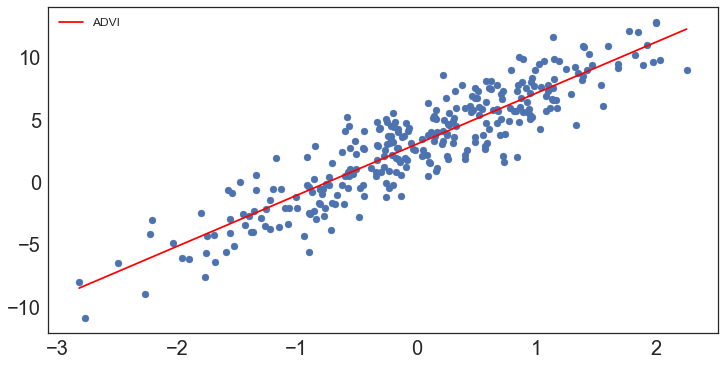

In [29]:
max_x = max(X_test)
min_x = min(X_test)

slope_learned = model.summary['mean']['betas__0_0']
intercept_learned = model.summary['mean']['alpha__0']
fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test)
ax1.plot([min_x, max_x], [slope_learned*min_x + intercept_learned, slope_learned*max_x + intercept_learned], 'r', label='ADVI')
ax1.legend();

In [30]:
model.save('pickle_jar/linear_model')

#### Use already trained model for prediction

In [31]:
model_new = LinearRegression()

In [32]:
model_new.load('pickle_jar/linear_model')

In [33]:
model_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2579.62it/s]


0.82851299087788477

## MCMC

In [34]:
model2 = LinearRegression()
model2.fit(X_train, y_train, inference_type='nuts')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s_log__, betas, alpha]
100%|██████████| 2500/2500 [00:02<00:00, 1158.56it/s]


LinearRegression()

### Diagnose convergence

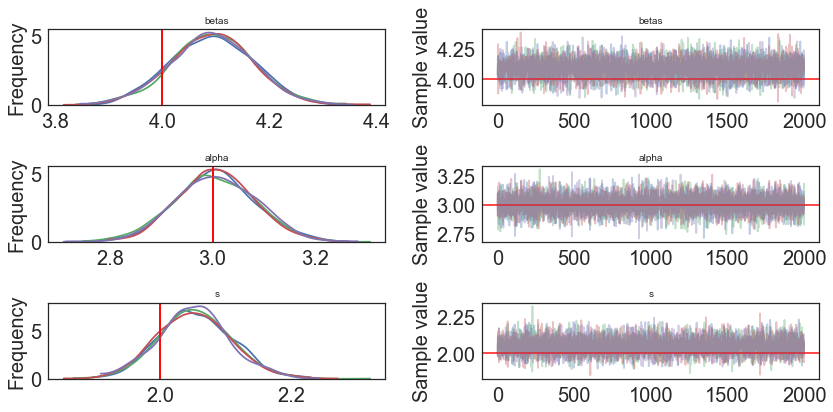

In [35]:
pm.traceplot(model2.trace, lines = {"betas": slope, 
                                 "alpha": intercept, 
                                 "s": 2}, 
             varnames=["betas", "alpha", "s"]);

In [40]:
pm.gelman_rubin(model2.trace, varnames=["betas", "alpha", "s"])

{'betas': array([[ 0.99986876]]),
 'alpha': array([ 1.00016225]),
 's': 1.0003069295511891}

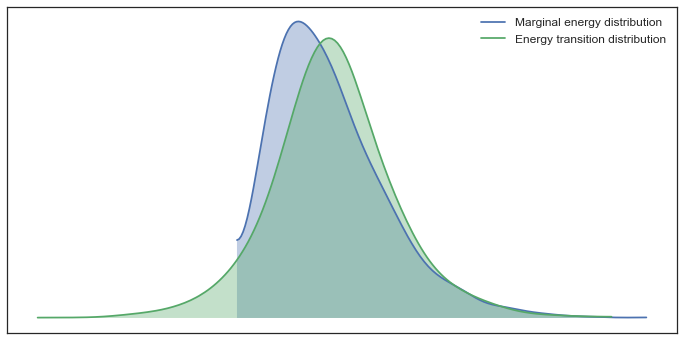

In [41]:
pm.energyplot(model2.trace);

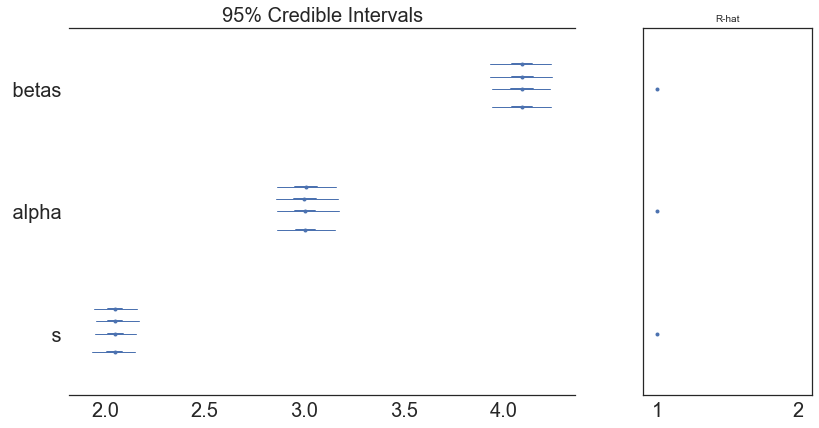

In [42]:
pm.forestplot(model2.trace, varnames=["betas", "alpha", "s"]);

### Criticize the model

In [43]:
pm.summary(model2.trace, varnames=["betas", "alpha", "s"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betas__0_0,4.091308,0.076976,0.000730,3.930080,4.234339,12005.659197,0.999869
alpha__0,3.005255,0.077417,0.000651,2.858690,3.158991,11889.939447,1.000162
s,2.051777,0.054695,0.000533,1.950242,2.167202,12755.864599,1.000307


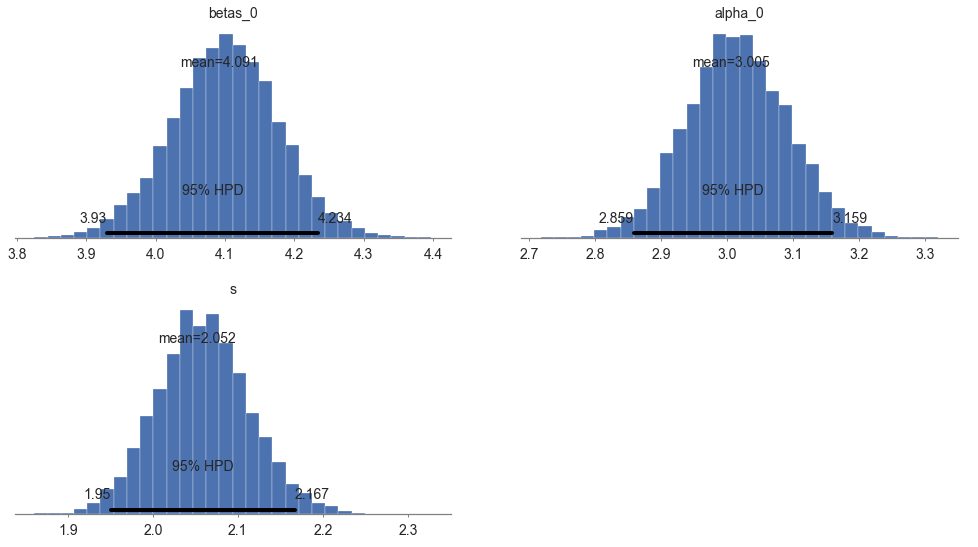

In [44]:
pm.plot_posterior(model2.trace, varnames=["betas", "alpha", "s"], 
                 figsize = [14, 8]);

### Use the model for prediction

In [45]:
y_predict2 = model2.predict(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 2489.86it/s]


In [46]:
model2.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2661.12it/s]


0.82796846444711492

Compare the two methods
===

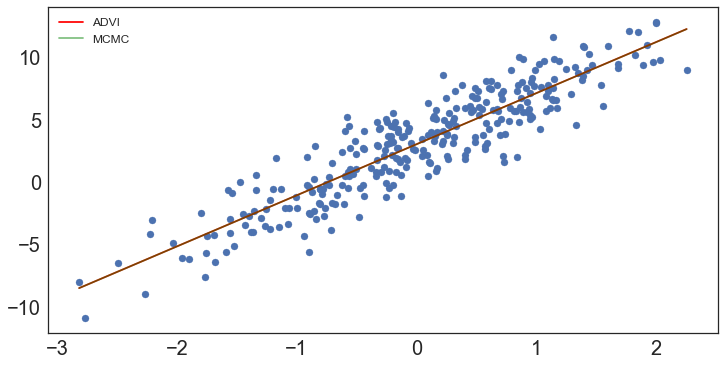

In [47]:
max_x = max(X_test)
min_x = min(X_test)

slope_learned = model.summary['mean']['betas__0_0']
intercept_learned = model.summary['mean']['alpha__0']

slope_learned2 = model2.summary['mean']['betas__0_0']
intercept_learned2 = model2.summary['mean']['alpha__0']

fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test)
ax1.plot([min_x, max_x], [slope_learned*min_x + intercept_learned, slope_learned*max_x + intercept_learned], 'r', label='ADVI')
ax1.plot([min_x, max_x], [slope_learned2*min_x + intercept_learned2, slope_learned2*max_x + intercept_learned2], 'g', label='MCMC', alpha=0.5)
ax1.legend();

In [49]:
model2.save('pickle_jar/linear_model2')
model2_new = LinearRegression()
model2_new.load('pickle_jar/linear_model2')
model2_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:00<00:00, 2500.20it/s]


0.82664121264536061

Multiple predictors
===

In [50]:
num_pred = 2
X = np.random.randn(1000, num_pred)
noise = 2 * np.random.randn(1000,)
y = X.dot(np.array([4, 5])) + 3 + noise
y = np.squeeze(y)

In [51]:
model_big = LinearRegression()

In [52]:
model_big.fit(X, y)

Average Loss = 2,114.4:  16%|█▌        | 31921/200000 [00:15<01:20, 2093.36it/s]
Convergence archived at 32100
Interrupted at 32,099 [16%]: Average Loss = 6,386.6


LinearRegression()

In [53]:
model_big.summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.944252,0.067351,0.000572,2.815493,3.075461
betas__0_0,3.983369,0.069744,0.000634,3.842738,4.114913
betas__0_1,4.870068,0.072868,0.000804,4.728200,5.013034
s,1.952041,0.047603,0.000439,1.857841,2.044785
